# Global Imports

In [61]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random

random.seed(42)

# Local Imports

In [62]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [63]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "FoxTrot"

# Define Paths
Workspace

In [64]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [65]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)


# Helper Functions

In [66]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [67]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels

In [68]:

labeled_image_paths: list[tuple[str, str]] = []

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))


# Load Dataset

In [69]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index],
    labels=labels[:split_index],
    all_label_classes=all_label_classes,
    rotation_limit=0.1,
    translation_limit=0.2,
    skew_limit=0.05,
    zoom_change=0.35,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    image_dims=(64, 64)
)




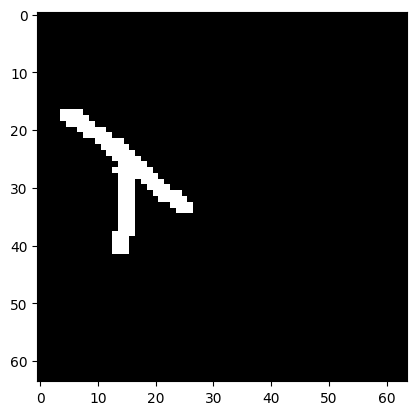

tensor([0., 0., 0., 0., 0., 1., 0.])


In [70]:
for im, lab in train_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

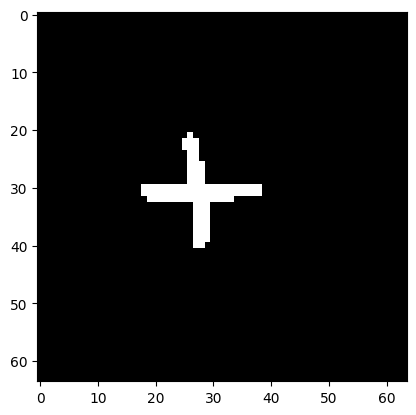

tensor([0., 0., 1., 0., 0., 0., 0.])


In [71]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [72]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

# Define Model Hyperparameters

In [73]:

model_checkpoint_path: str = os.path.join(
    model_save_dirpath,
    "Echo_epoch10_trainacc0.61397_valacc0.84058.pkl"
)

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 16, 16, 16, 16, 16, 32),
        "fully_connected_features": (7,),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.05,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": model_checkpoint_path
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.001,
        "weight_decay": 0.0001
    }
]


In [74]:
len(val_dataloader)

5

# Train

In [75]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=20,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        train_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Training model...:  41%|████      | 7/17 [00:05<00:08,  1.21it/s]


KeyboardInterrupt: 